In [ ]:
from pathlib import Path

import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
import torch
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps

from surface_utils import FlatResampler, load_flat, extract_valid_flat

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
ROOT = Path("/home/connor/algonauts2025.clean")
print(ROOT)

SUBJECTS = (1, 2, 3, 5)

PIXEL_SIZE = 1.2
RECT = (-330.0, 330.0, -150.0, 160.0)

/home/connor/algonauts2025.clean


In [3]:
plt.style.use("clane.mplstyle")
plt.rcParams["figure.dpi"] = 350
PLOTW = 3.5

In [4]:
def load_resampler_parc() -> tuple[FlatResampler, np.ndarray]:
    parc = nib.load(ROOT / "Schaefer2018_1000Parcels_7Networks_order.dlabel.nii")
    parc = parc.get_fdata().squeeze().astype(np.int32)

    mask = parc > 0
    flat = load_flat("32k_fs_LR")
    flat, mask = extract_valid_flat(flat, mask)

    resampler = FlatResampler(pixel_size=PIXEL_SIZE, rect=RECT)
    resampler.fit(flat)

    parc_flat = resampler.transform(parc[mask], interpolation="nearest")

    N, P = int(resampler.mask_.sum()), int(parc.max())
    parc_one_hot = np.zeros((N, P))
    parc_indices = parc_flat[resampler.mask_].astype(np.int64) - 1
    parc_one_hot[np.arange(N), parc_indices] = 1.0
    return resampler, parc_one_hot

In [5]:
def map_to_flat(
    resampler: FlatResampler,
    parc_one_hot: np.ndarray,
    data: np.ndarray,
):
    assert data.ndim == 1
    H, W = resampler.mask_.shape
    flat_data = np.full((H, W), fill_value=np.nan, dtype=data.dtype)
    flat_data[resampler.mask_] = parc_one_hot @ data
    return flat_data

In [6]:
resampler, parc_one_hot = load_resampler_parc()

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [7]:
feat_enc_ckpt_path = ROOT / "output/feature_encoding_default_2507211453/ckpt.pt"
feat_enc_ckpt = torch.load(feat_enc_ckpt_path, map_location="cpu", weights_only=False)

In [8]:
schaefer_flat_masks = np.load("schaefer_flat_masks.npz")
default_boundary_flat = schaefer_flat_masks["default_boundary_flat"]
vis_boundary_flat = schaefer_flat_masks["vis_boundary_flat"]
# schaefer_boundary_flat = default_boundary_flat | vis_boundary_flat
schaefer_boundary_flat = default_boundary_flat
resampler.mask_.shape, schaefer_boundary_flat.shape

((258, 550), (258, 550))

In [9]:
metrics = feat_enc_ckpt["metrics"]
print(metrics.keys())
print(metrics["val_s6"].keys())

dict_keys(['val_s6', 'val_figures', 'val_life'])
dict_keys(['accmap_sub-1', 'acc_sub-1', 'accmap_sub-2', 'acc_sub-2', 'accmap_sub-3', 'acc_sub-3', 'accmap_sub-5', 'acc_sub-5', 'accmap_avg', 'acc_avg'])


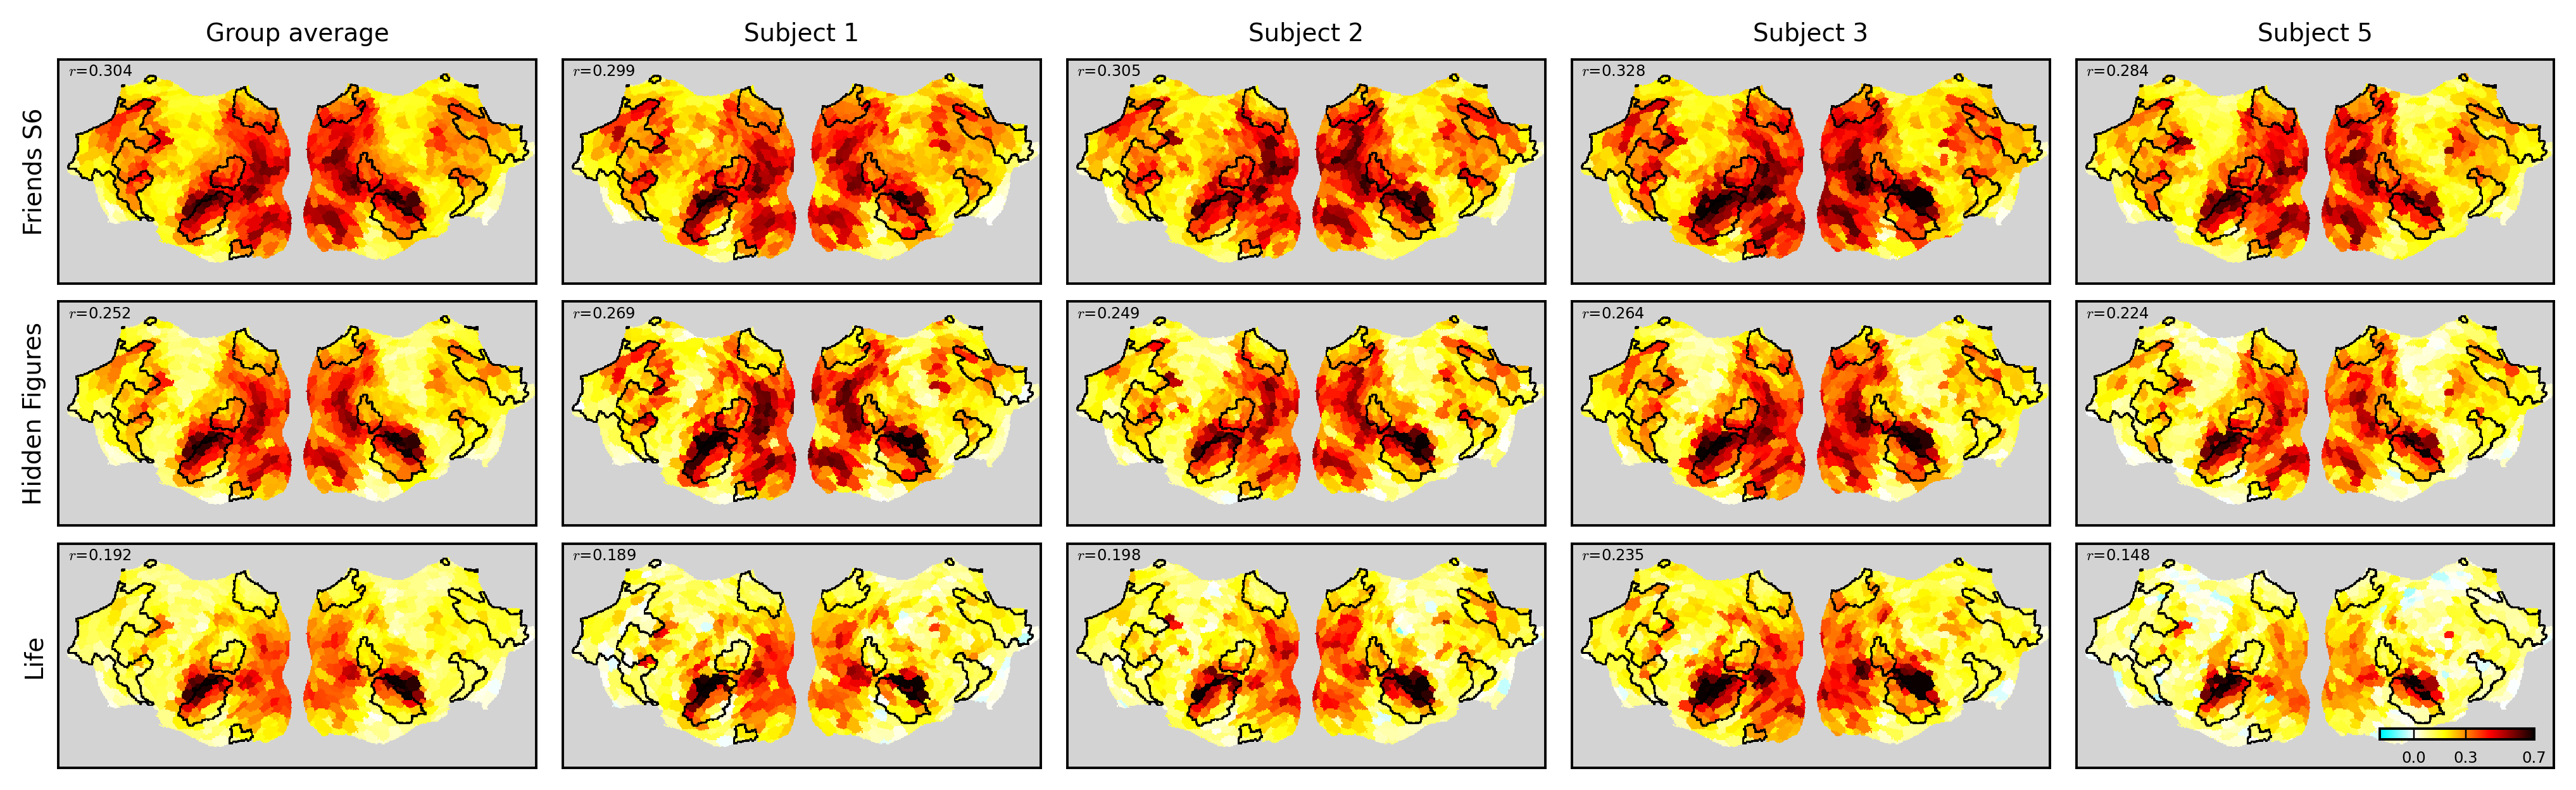

In [19]:
H, W = resampler.mask_.shape

nr = 3
nc = 5
plotw = 2 * PLOTW / 3
ploth = 1.1 * H / W * plotw

f, axs = plt.subplots(nr, nc, figsize=(nc * plotw, nr * ploth))

splits = {
    "val_s6": "Friends S6",
    "val_figures": "Hidden Figures",
    "val_life": "Life",
}

vmax = 0.7
vmin = -vmax
cmap = nilearn_cmaps["cold_white_hot"]
cmap.set_bad("lightgray")

for ii, (split, title) in enumerate(splits.items()):
    plt.sca(axs[ii, 0])
    accmap = metrics[split]["accmap_avg"]
    mean_acc = accmap.mean()
    accmap_flat = map_to_flat(resampler, parc_one_hot, accmap)
    img = plt.imshow(accmap_flat, cmap=cmap, interpolation="none", vmin=vmin, vmax=vmax)
    plt.imshow(
        np.where(schaefer_boundary_flat, 0.0, np.nan),
        cmap="gray",
        interpolation="none",
        vmin=0,
        vmax=1,
    )
    plt.text(
        0.02,
        0.98,
        f"$r$={mean_acc:.3f}",
        ha="left",
        va="top",
        fontsize=5,
        transform=axs[ii, 0].transAxes,
    )
    plt.xticks([])
    plt.yticks([])
    if ii == 0:
        plt.title("Group average", fontsize=8)
    plt.ylabel(title, fontsize=8)

    for jj, sub in enumerate(SUBJECTS):
        plt.sca(axs[ii, jj + 1])
        accmap = metrics[split][f"accmap_sub-{sub}"]
        mean_acc = accmap.mean()
        accmap_flat = map_to_flat(resampler, parc_one_hot, accmap)
        img = plt.imshow(
            accmap_flat, cmap=cmap, interpolation="none", vmin=vmin, vmax=vmax
        )
        plt.imshow(
            np.where(schaefer_boundary_flat, 0.0, np.nan),
            cmap="gray",
            interpolation="none",
            vmin=0,
            vmax=1,
        )
        plt.text(
            0.02,
            0.98,
            f"$r$={mean_acc:.3f}",
            ha="left",
            va="top",
            fontsize=5,
            transform=axs[ii, jj + 1].transAxes,
        )
        plt.xticks([])
        plt.yticks([])
        if ii == 0:
            plt.title(f"Subject {sub}", fontsize=8)

plt.tight_layout()

axins = inset_axes(
    axs[-1, -1],
    width="33%",
    height="5%",
    loc="lower right",
    bbox_to_anchor=(0, 0.08, 0.98, 1),  # (l, b, w, h)
    bbox_transform=axs[-1, -1].transAxes,
)
axins.xaxis.set_ticks_position("bottom")
cbar = f.colorbar(img, cax=axins, orientation="horizontal")

cbar.ax.set_xlim([-0.2, vmax])
cbar.ax.set_xticks([0.0, 0.3, 0.7])
cbar.ax.tick_params(labelsize=5)

plt.savefig("output/feature_encoding_flat_maps.png", bbox_inches="tight")